In [1]:
import json
from dataclasses import dataclass
from pathlib import Path
import shutil
import subprocess
import shlex

from intervaltree import IntervalTree
from minio import Minio
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

# Requirements:
# pip install intervaltree minio pillow tqdm

In [2]:
# docker logs seafowl 2>&1 | grep LOGTRACE > initial.txt
FILE = "initial.txt"

# timescale, e.g. 300 == 300x slower
scale = 1

# fps for final video
fps = 60

# Minio client instance to get file sizes
minio = Minio(endpoint="localhost:9000", secure=False)

In [282]:
@dataclass(frozen=True)
class CacheEvent:
    event: str
    filename: str
    range_start: int
    range_end: int
    event_start: int
    event_end: int

In [5]:
files = [
    (o.object_name, o.size)
    for o in minio.list_objects("delta", recursive=True)
    if "lineitem" in o.object_name and "public/" in o.object_name and "_delta_log" not in o.object_name
]

In [286]:
with open(FILE, "r") as f:
    events = [json.loads(l.strip())["fields"] for l in f.readlines()]

parsed_events: list[CacheEvent] = []
for event in events:
    parsed_events.append(CacheEvent(
        event=event["event"],
        filename = event["filename"],
        range_start = event["range_start"],
        range_end = event["range_end"],
        event_start = int(event["start"]),
        event_end = int(event["end"]),
    ))

tree = IntervalTree()
for event in parsed_events:
    tree[event.event_start:event.event_end] = event

In [288]:
@dataclass(frozen=True)
class EventStatus:
    events_in_flight: list[CacheEvent]
    chunks_in_cache: list[tuple[str, int, int]]

def get_events_at(tree: IntervalTree, timestamp: int) -> EventStatus:
    events_in_flight = [e.data for e in tree.at(timestamp)]
    chunks_in_cache = []

    for interval in tree[:timestamp]:
        event = interval.data
        if event.event == 'write_file' and interval.end < timestamp:
            chunks_in_cache.append((event.filename, event.range_start, event.range_end))
        if event.event == 'cache_eviction' and interval.end < timestamp:
            try:
                chunks_in_cache.remove((event.filename, event.range_start, event.range_end))
            except ValueError:
                pass

    return EventStatus(events_in_flight=events_in_flight, chunks_in_cache=chunks_in_cache)

@dataclass(frozen=True)
class RenderSettings:
    image_width: int
    image_height: int
    # File paths and their sizes
    files: list[tuple[str, int]]
    timestamp_position: tuple[float, float]
    timestamp_size: int
    file_status_bbox: tuple[float, float, float, float]
    file_status_columns: int
    # pixels
    file_status_padding: float
    file_status_name_position: tuple[float, float]
    file_status_name_size: int
    file_status_chunk_bbox: tuple[float, float, float, float]

@dataclass(frozen=True)
class FileLayout:
    file_name_position: tuple[int, int]
    chunk_box: tuple[int, int, int, int]
    file_size: int


@dataclass(frozen=True)
class ComputedLayout:
    image_width: int
    image_height: int
    timestamp_position: tuple[int, int]
    timestamp_size: int
    file_name_size: int
    file_layout: dict[str, FileLayout]


def compute_layout(settings: RenderSettings) -> ComputedLayout:
    image_width = settings.image_width
    image_height = settings.image_height
    timestamp_position = (round(settings.timestamp_position[0] * image_width), round(settings.timestamp_position[1] * image_height))
    timestamp_size = settings.timestamp_size

    # bbox in image pixel space for file status
    file_status_bbox = (
        round(settings.file_status_bbox[0] * image_width),
        round(settings.file_status_bbox[1] * image_height),
        round(settings.file_status_bbox[2] * image_width),
        round(settings.file_status_bbox[3] * image_height),
    )

    # for each file, figure out its bbox
    total_rows = -(len(settings.files) // -settings.file_status_columns)

    file_status_width = round((file_status_bbox[2] - file_status_bbox[0] - (1 + settings.file_status_columns) * settings.file_status_padding) / settings.file_status_columns)
    file_status_height = round((file_status_bbox[3] - file_status_bbox[1] - (1 + total_rows) * settings.file_status_padding) / total_rows)

    # print(f"total rows: {total_rows}")
    # print(f"file status width: {file_status_width}")
    # print(f"file status height: {file_status_height}")
    # print(f"file status bbox: {file_status_bbox}")

    file_layouts = {}
    
    for i, (file_path, file_size) in enumerate(settings.files):
        col = i % settings.file_status_columns
        row = i // settings.file_status_columns
        
        x0 = file_status_bbox[0] + settings.file_status_padding + col * (settings.file_status_padding + file_status_width)
        x1 = x0 + file_status_width
        y0 = file_status_bbox[1] + settings.file_status_padding + row * (settings.file_status_padding + file_status_height)
        y1 = y0 + file_status_height

        file_status_name_position = (x0 + settings.file_status_name_position[0] * (x1 - x0),
                                     y0 + settings.file_status_name_position[1] * (y1 - y0))
    

        # compute the chunk progressbar bbox
        file_status_chunk_bbox = (
            x0 + settings.file_status_chunk_bbox[0] * (x1 - x0),
            y0 + settings.file_status_chunk_bbox[1] * (y1 - y0),
            x0 + settings.file_status_chunk_bbox[2] * (x1 - x0),
            y0 + settings.file_status_chunk_bbox[3] * (y1 - y0),
        )

        # TODO scale as per file size
        file_layouts[file_path] = FileLayout(
            file_name_position = file_status_name_position,
            file_size = file_size,
            chunk_box = file_status_chunk_bbox
        )

    return ComputedLayout(
        image_width = image_width,
        image_height = image_height,
        timestamp_position = timestamp_position,
        timestamp_size = timestamp_size,
        file_name_size = settings.file_status_name_size,
        file_layout = file_layouts
    )

def get_file_bbox(layout: ComputedLayout, file: str, chunk_start: int, chunk_end: int) -> tuple[int, int, int, int]:
    file_layout = layout.file_layout[file]
    x0 = file_layout.chunk_box[0] + (chunk_start / file_layout.file_size) * (file_layout.chunk_box[2] - file_layout.chunk_box[0])
    x1 = file_layout.chunk_box[0] + (chunk_end / file_layout.file_size) * (file_layout.chunk_box[2] - file_layout.chunk_box[0])

    return (x0, file_layout.chunk_box[1], x1, file_layout.chunk_box[3])

In [304]:
start = min(tree).begin
end = max(tree).end
duration = (end - start) / 1e9 * scale

In [305]:
layout = compute_layout(RenderSettings(
    image_width=1920,
    image_height=1080,
    files=files,
    timestamp_position = (0.05, 0.05),
    timestamp_size = 48,
    file_status_bbox = (0.05, 0.1, 0.95, 0.95),
    file_status_columns = 3,
    # pixels
    file_status_padding = 10,
    file_status_name_position = (0, 0),
    file_status_name_size = 12,
    file_status_chunk_bbox = (0., 0.2, 1., 1.),
))
# layout

In [306]:
def render_frame(timestamp: int, status: EventStatus, layout: ComputedLayout):
    image = Image.new(mode="RGB", size=(layout.image_width, layout.image_height), color="white")

    draw = ImageDraw.Draw(image)
    
    # Draw timestamp
    timestamp_font = ImageFont.load_default(size=layout.timestamp_size)
    timestamp_str = dt.utcfromtimestamp(timestamp / 1e9).isoformat()
    draw.text(layout.timestamp_position, timestamp_str, font=timestamp_font, fill="black")

    # Draw files
    file_name_font = ImageFont.load_default(size=layout.file_name_size)
    for file_name, file_layout in layout.file_layout.items():
        draw.text(file_layout.file_name_position, file_name, font=file_name_font, fill="black")

        draw.rectangle(file_layout.chunk_box, outline="black")

    # Draw cache
    for filename, start, end in status.chunks_in_cache:
        bbox = get_file_bbox(layout, filename, start, end)
        draw.rectangle(bbox, outline=None, fill="green")

    # Draw DF requests
    for event in status.events_in_flight:
        bbox = get_file_bbox(layout, event.filename, event.range_start, event.range_end)
        if event.event == "get_range_request":
            draw.rectangle(bbox, outline="red", fill=None)
        elif event.event == "get_range_outbound":
            draw.rectangle(bbox, outline="blue", fill=None)
        elif event.event == "cache_read_disk":
            draw.rectangle(bbox, outline=None, fill="blue")
        elif event.event == "cache_read_memory":
            draw.rectangle(bbox, outline=None, fill="blue")
        elif event.event == "write_file":
            draw.rectangle(bbox, outline=None, fill="green")
    
    return image

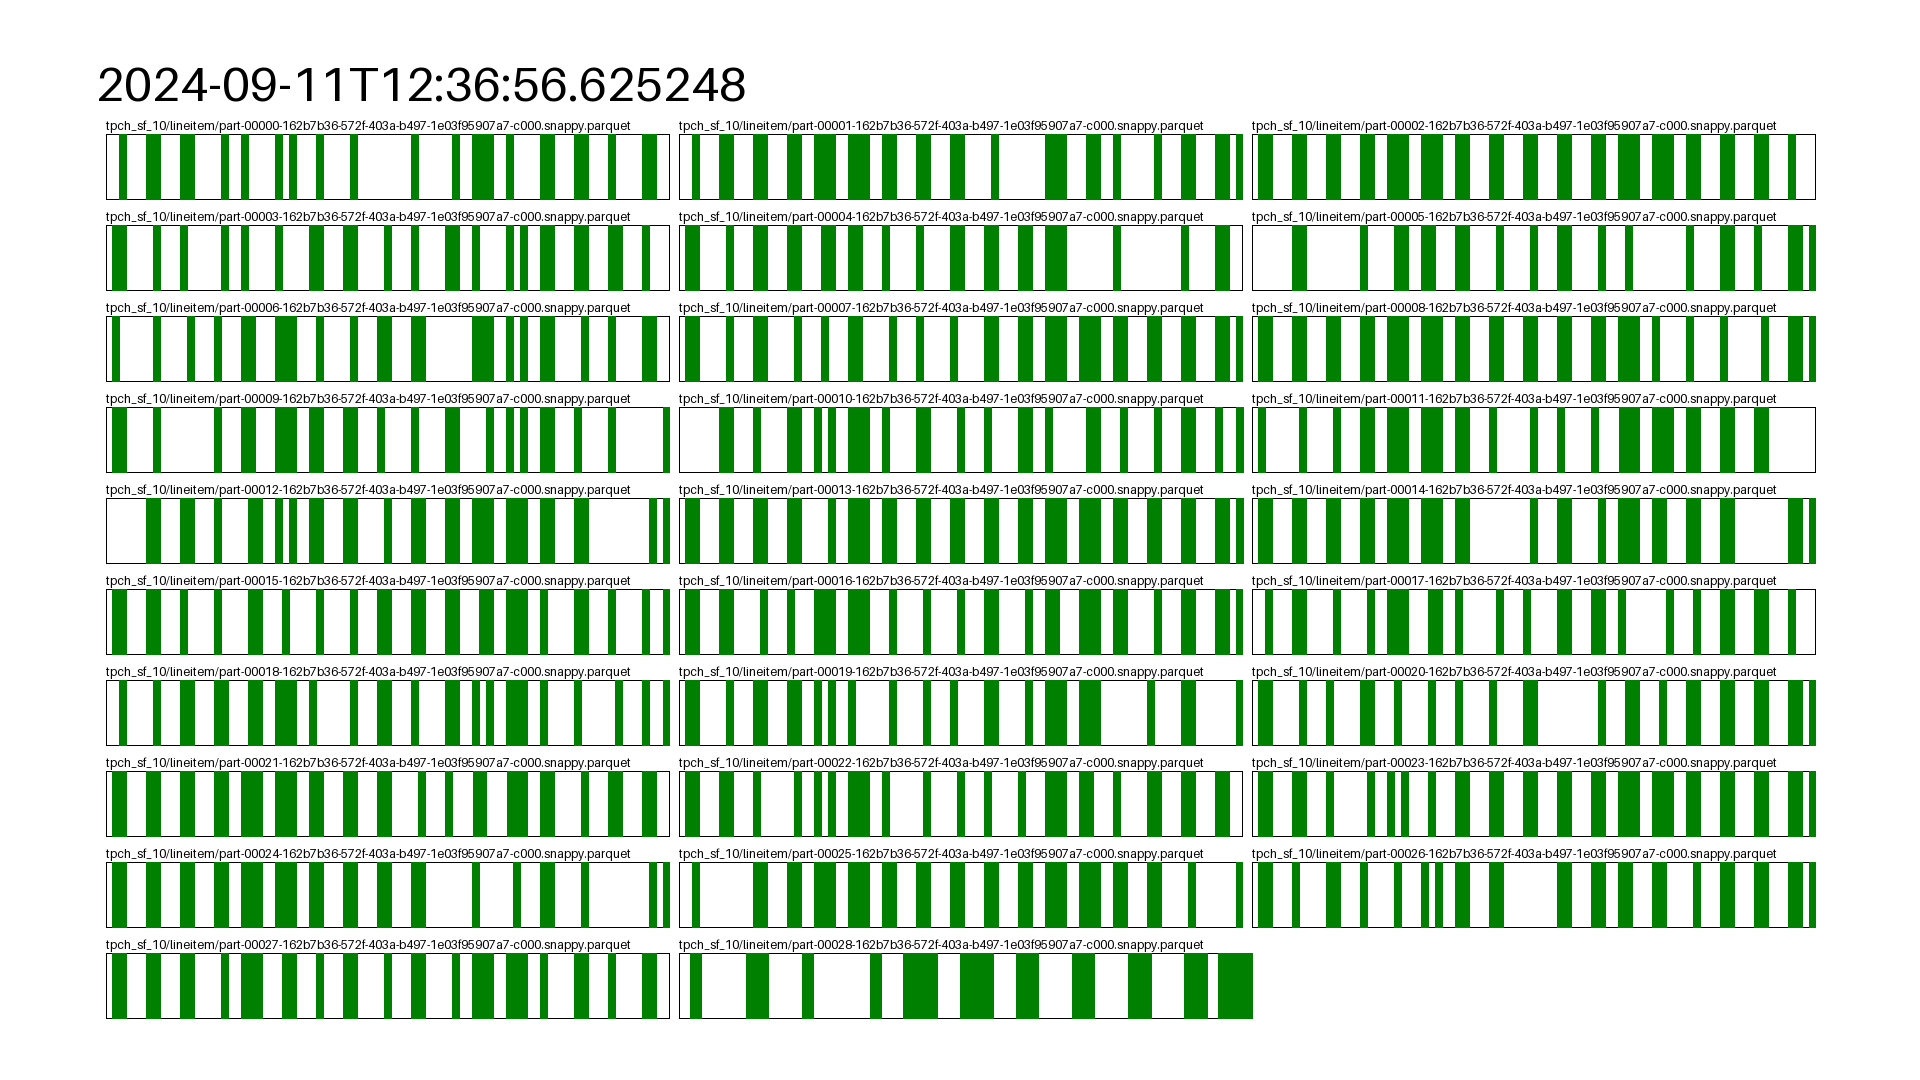

In [307]:
timestamp = end
status = get_events_at(tree, end)
render_frame(end - 1e10, status, layout)

In [308]:
path = Path("./frames")
shutil.rmtree(path, ignore_errors=True)
path.mkdir()

for frame in tqdm(list(range(int(fps * duration)))):
    timestamp = int(start + (frame / fps / float(scale)) * 1e9)
    timestamp_str = dt.utcfromtimestamp(timestamp / 1e9).isoformat()
    status = get_events_at(tree, timestamp)
    img = render_frame(timestamp, status, layout)
    img.save(path / Path(f"frame_{frame:06d}.png"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3651/3651 [10:53<00:00,  5.59it/s]


In [309]:
subprocess.check_output(
    ["ffmpeg", "-r", str(fps), "-i", "frame_%06d.png", "-vcodec", "mpeg4", "-y", "cache.mp4"],
    cwd="./frames"
)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

b''